# Capstone Project -- Flatiron Data Science Final Project

Name: Brian Caterfino

Instructor: Rafael Carrasco

Pace: Full Time

Data: https://www.kaggle.com/zynicide/wine-reviews

Blog Post: https://medium.com/@bcDS/capstone-project-abstract-58813cd009b6

# WIne Review Analysis

#### In this project, I seek to showcase my knowledge gained from the Flatiron Data Science Program by using data science to analyze the Kaggle dataset chronicling 130,000 reviews of wine bottles, with features such as description, country, rating, price, and others.

The first step is to import/install all necessary python libraries.

In [3]:
import operator
import string
import itertools
import statistics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)

from sklearn import preprocessing, svm, datasets
from sklearn.utils.fixes import signature
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import LabelEncoder

import nltk
import nltk.data
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

import keras
from keras.layers import LSTM, GRU, Dense, GlobalMaxPool1D, Embedding, Dropout, Activation, Input
from keras.preprocessing import text, sequence
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from wordcloud import WordCloud

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec

In [ ]:
print)

## Obtaining Data -- Importing the Kaggle dataset into this Jupyter Notebook

Here, the data is imported via pandas into a dataframe, and then the first few elements are inspected.

In [2]:
df0 = pd.read_csv('winemag-data-130k-v2.csv', index_col=0) #importing the dataset
df0.head(3) #Taking a look at the first 3 listings

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


## Exploring Data Analysis

#### In the EDA phase of this project, it is crucial to get an understanding for the dataset. Attributes to look at that may help one understand their dataset are: shape, null values, features, feature value counts, datatypes, and distribution.

In [3]:
df00 = df0.drop(columns= 'taster_twitter_handle')#Getting rid of one irrelevant feature
df00.shape #Checking the shape

(129971, 12)

In [4]:
df00.isnull().sum() #Looking at the amount of null values per feature

country           63
description        0
designation    37465
points             0
price           8996
province          63
region_1       21247
region_2       79460
taster_name    26244
title              0
variety            1
winery             0
dtype: int64

#### There are two methods for filling the price columns null values. I could remove all the rows that don't have a price value, or I could fill those in with the median price.


In [5]:
pricemedian = df00.price.median() #Storing median price as variable

In [6]:
df00.price.fillna(pricemedian, inplace = True) #Replace null values with median
df= df00#Convert to df
df.price.isnull().sum() # test if this worked
#df = df00.dropna(subset=['price'])

0

#### Some of the non-important features must be dropped, and some potentially useful features procured through feature engineering must be added. Also, it is important to remove or fill all null/NaN values.

In [7]:
#Make a list of all the column names that I won't use in order to remove
addnonelist =['designation' , 'region_1' , 'region_2' , 'region_1' , 'taster_name' , 'country' , 'variety' , 'province']
for x in addnonelist:
    df[x].fillna('None', inplace = True) # Get rid of these columns
df['Value Ratio'] = df['points'] / df['price'] # Feature engineer a Value column
df['Positive'] = 0 # Create new column, that wil denote whether the review is above or below the mean, to be populated later

In [8]:
df.head(3)

,country,description,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery,Value Ratio,Positive
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,25.0,Sicily & Sardinia,Etna,None,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,3.480000,0
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,None,None,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,5.800000,0
2,US,"Tart and snappy, the flavors of lime flesh and...",None,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,6.214286,0


In [9]:
scoremean = df.points.mean()
range(len(df.points))

range(0, 129971)

In [10]:
df.isnull().sum() #Lets see if there are still null values

country        0
description    0
designation    0
points         0
price          0
province       0
region_1       0
region_2       0
taster_name    0
title          0
variety        0
winery         0
Value Ratio    0
Positive       0
dtype: int64

In [11]:
df.info() #Checking the datatypes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 14 columns):
country        129971 non-null object
description    129971 non-null object
designation    129971 non-null object
points         129971 non-null int64
price          129971 non-null float64
province       129971 non-null object
region_1       129971 non-null object
region_2       129971 non-null object
taster_name    129971 non-null object
title          129971 non-null object
variety        129971 non-null object
winery         129971 non-null object
Value Ratio    129971 non-null float64
Positive       129971 non-null int64
dtypes: float64(2), int64(2), object(10)
memory usage: 14.9+ MB


In [12]:
df.shape #one final check of the shape

(129971, 14)

In [13]:
df.price.describe() #This shows the distribution of the price feature

count    129971.000000
mean         34.646083
std          39.664385
min           4.000000
25%          18.000000
50%          25.000000
75%          40.000000
max        3300.000000
Name: price, dtype: float64

#### This graph shows the distribution of the points features.

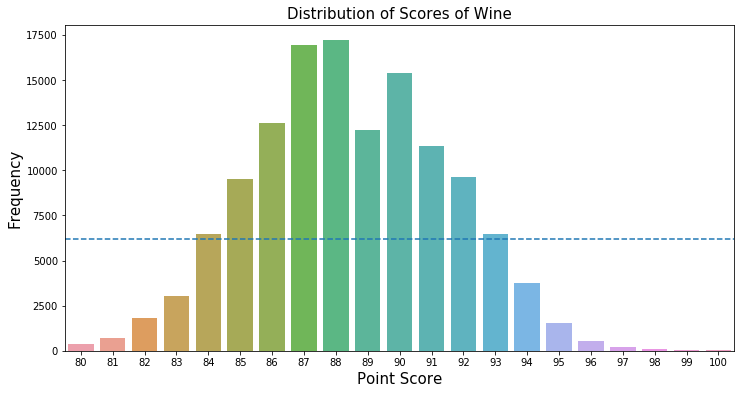

In [14]:
#Creating histogrm of different scores
ptvals  = df['points'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(ptvals.index, ptvals.values, alpha=0.9)
plt.axhline(statistics.mean(ptvals), ls='--')
plt.title('Distribution of Scores of Wine', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Point Score', fontsize=15)
plt.show()

In [15]:
print(df.price.corr(df.points))
print(df.price.mean())
print(df.price.std())
print(df.price.quantile(.99))

0.39923085896907584
34.64608258765417
39.66438463051558
150.0


#### Now, removing some of the outlier values will make our graphs more useful, without sacrificing too much information.

In [16]:
df = df.loc[df.price < 150] # Get rid of price outliers above 99th percentile
df = df.loc[df['Value Ratio'] < 10] #Get rid of outliers in value column

In [17]:
df['Value Ratio'].max()

9.88888888888889

#### There is clearly some causation between the price and the review score, but the correlation appears to be pretty low.. This scatter plot does not show much valuable information, so other methods must be used.

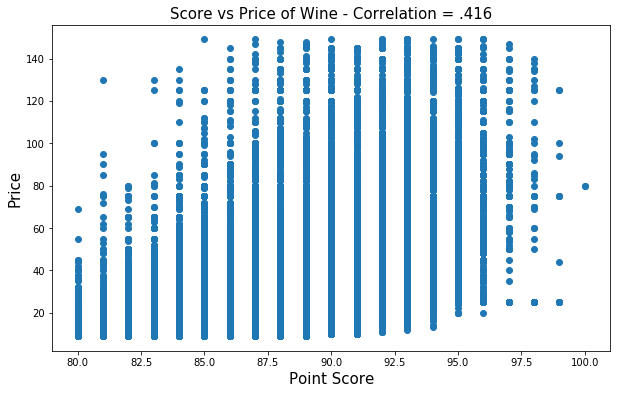

In [18]:
#Creating a scatterplot of score v price, resulting plot not very informative
plt.figure(figsize=(10,6))
plt.scatter(df.points, df.price)
plt.title('Score vs Price of Wine - Correlation = .416', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.xlabel('Point Score', fontsize=15)
plt.show()

In [19]:
dfpt80= df.loc[df['points'] == 85] #Test code for finding mean per score
dfpt80['price'].mean()

20.638873790629415

In [20]:
pointspricemeans=[] #Create list to be populated with mean per score
pointspricemeans.append(df.loc[df['points'] == 80].mean())
print(pointspricemeans)

[points         80.000000
price          17.367688
Value Ratio     5.416746
Positive        0.000000
dtype: float64]


In [21]:
pointspricemeans=[] #Now to create a plot of this relationship
for x in list(range(80,101)):
    z = df.loc[df['points'] == x]
    pointspricemeans.append(z['price'].mean())

#### With the outliers removed, a bar chart of the mean prices of different scores shows us the relationship more clearly. (Without removing outliers, the graph continuously grows, instead of trending downward after 98.)

In [22]:
pm = statistics.mean(pointspricemeans)

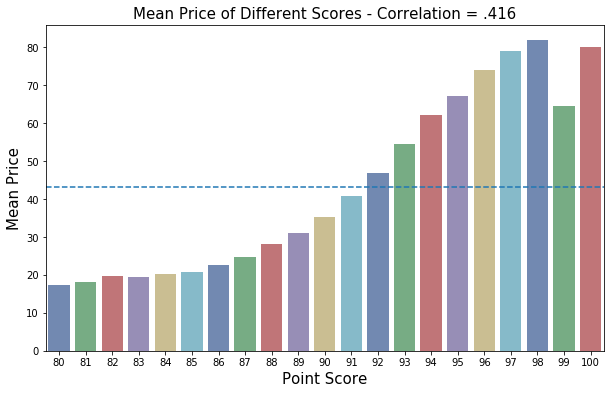

In [23]:
#This is the code that creates the graph
plt.figure(figsize=(10,6))
sns.barplot(list(range(80,101)), pointspricemeans, palette="deep", alpha = .85)
plt.axhline(pm, ls='--')
plt.title('Mean Price of Different Scores - Correlation = .416', fontsize=15)
plt.ylabel('Mean Price', fontsize=15)
plt.xlabel('Point Score', fontsize=15)
plt.show()

In [24]:
df.price.quantile(.99)

115.0

In [25]:
df.groupby('variety', as_index=False)['price'].mean().min()[1] #Start looking into price per type of wine

9.0

#### In order to make an informative graphic, I scale the price and value features to be between 80-100, just like the points features, then plot them all together by different categories of wine.

In [26]:
#Storing these variables will make data exploration easier for the next steps
min1 = df.price.min()
max1 = df.price.max()

min2 = df.points.min()
max2 = df.points.max()

min3 = df['Value Ratio'].min()
max3 = df['Value Ratio'].max()

In [27]:
#Storing the original columns, preparing to scale the price and value to be between 80-100
df['OPrice'] = df.price
df['OValue Ratio'] = df['Value Ratio']
df.opoints = df.points

C:\Users\Brian\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.


In [28]:
df.head(2)

,country,description,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery,Value Ratio,Positive,OPrice,OValue Ratio
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,25.0,Sicily & Sardinia,Etna,None,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,3.48,0,25.0,3.48
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,None,None,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,5.80,0,15.0,5.80


In [29]:
#This code scales the price and value between 80-100
X_std = (df.price - min1) * (100 - 80) / (max1 - min1) + 80
df.price = X_std

X_std3 = (df['Value Ratio'] - min3) * (100 - 80) / (max3 - min3) + 80
df['Value Ratio'] = X_std3

In [30]:
#Now to prepare to graph 3 graphs, making lists of the top 10 and top 100 most common types of wine
topfreqtypelist100 = df.variety.value_counts().index.tolist()[0:100]
topfreqtypelist10 = df.variety.value_counts().index.tolist()[0:10]

In [31]:
# This populates lists to keep track of the means of price, value, and points per different category
meanvaluelist1=[]
pricelist1=[]
scorelist1=[]
for x in topfreqtypelist100:
    z = df.loc[df['variety'] == x]
    meanvaluelist1.append(z['Value Ratio'].mean())
    pricelist1.append(z['price'].mean())
    scorelist1.append(z['points'].mean())
    
meanvaluelist2=[]
pricelist2=[]
scorelist2=[]
for x in topfreqtypelist10:
    z = df.loc[df['variety'] == x]
    meanvaluelist2.append(z['Value Ratio'].mean())
    pricelist2.append(z['price'].mean())
    scorelist2.append(z['points'].mean())

In [32]:
#Create 6 dictionaries to store variables for the three different graphs
dictionary1 = dict(zip(topfreqtypelist100, meanvaluelist1))
dictionary2 = dict(zip(topfreqtypelist10, meanvaluelist2))
dictionary3 = dict(zip(topfreqtypelist100, pricelist1))
dictionary4 = dict(zip(topfreqtypelist10, pricelist2))
dictionary5 = dict(zip(topfreqtypelist100, scorelist1))
dictionary6 = dict(zip(topfreqtypelist10, scorelist2))

In [33]:
#This sorts the dictionaries to get only the top 10 values per metric
sorteddict1 = sorted(dictionary1.items(), key=operator.itemgetter(1), reverse = True)
sorteddict11 = sorted(dictionary1.items(), key=operator.itemgetter(1))
sorteddict10 = sorted(dictionary2.items(), key=operator.itemgetter(1), reverse = True)
sorteddict100best = sorteddict1[0:10]
sorteddict100worst = sorteddict11[0:10]

In [34]:
#This sorts the dictionaries to get only the top 10 values per metric
sorteddict2 = sorted(dictionary3.items(), key=operator.itemgetter(1), reverse = True)
sorteddict22 = sorted(dictionary3.items(), key=operator.itemgetter(1))
sorteddict210 = sorted(dictionary4.items(), key=operator.itemgetter(1), reverse = True)
sorteddict2100best = sorteddict2[0:10]
sorteddict2100worst = sorteddict22[0:10]

In [35]:
#This sorts the dictionaries to get only the top 10 values per metric
sorteddict3 = sorted(dictionary5.items(), key=operator.itemgetter(1), reverse = True)
sorteddict33 = sorted(dictionary5.items(), key=operator.itemgetter(1))
sorteddict310 = sorted(dictionary6.items(), key=operator.itemgetter(1), reverse = True)
sorteddict3100best = sorteddict3[0:10]
sorteddict3100worst = sorteddict33[0:10]

In [36]:
#Now to create dictionaries to plot all findings next to each other
sd10keys = []
for x in range(0,10):
    sd10keys.append(sorteddict10[x][0])    

In [37]:
#Now to create dictionaries to plot all findings next to each other
sd100bkeys = []
for x in range(0,10):
    sd100bkeys.append(sorteddict100best[x][0])

In [38]:
#Now to create dictionaries to plot all findings next to each other
sd100wkeys = []
for x in range(0,10):
    sd100wkeys.append(sorteddict100worst[x][0])

In [39]:
#This code is simply organizational to best plot the findings
dict1 = dict(sorteddict10)
dict2 = dict(sorteddict100best)
dict3 = dict(sorteddict100worst)

dict4 = dict(sorteddict210)
dict5 = dict(sorteddict2100best)
dict6 = dict(sorteddict2100worst)

dict7 = dict(sorteddict310)
dict8 = dict(sorteddict3100best)
dict9 = dict(sorteddict3100worst)

In [40]:
dict1['Merlot']

87.82553866073472

In [41]:
print(dictionary1['Merlot'])
print(dictionary3['Merlot'])
print(dictionary5['Merlot'])

print(dictionary2['Merlot'])
print(dictionary4['Merlot'])
print(dictionary6['Merlot'])

87.82553866073472
82.67346259861229
87.23020625415835
87.82553866073472
82.67346259861229
87.23020625415835


#### After much convoluted dictionary building, three graphs are ready t be plotted:

#### 1) Of the 100 most common categories of wine, the top 10 ranked by value, showing value, price, and points scaled between 80-100.

#### 2) Of the 100 most common categories of wine, the worst 10 ranked by value, showing value, price, and points scaled between 80-100.

#### 3) Of the 10 most common categories of wine, the top 10 ranked by value, showing value, price, and points scaled between 80-100.

### 1) Of the 100 most common categories of wine, the top 10 ranked by value, showing value, price, and points scaled between 80-100.

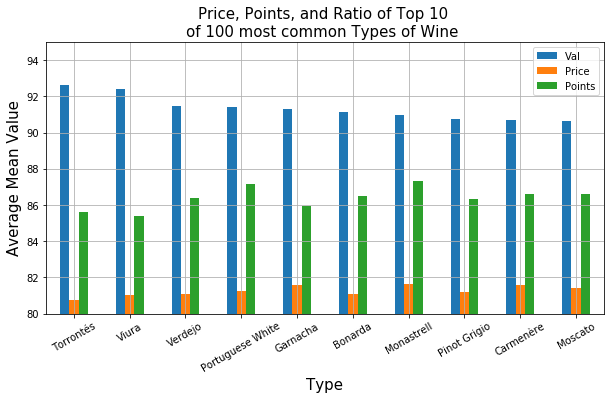

<Figure size 360x1152 with 0 Axes>

In [42]:
z=[]
zz=[]
zzz=[]
for x in sd100bkeys:
    index = sd100bkeys
    z.append(dictionary1[x])
    zz.append(dictionary3[x])
    zzz.append(dictionary5[x])

df2 = pd.DataFrame({'Val': z,
                    'Price': zz, 'Points': zzz},index=index)

ax = df2.plot.bar(rot=0, figsize = (10,5))
ax.set_ylim([80,95])
plt.ylabel('Average Mean Value', fontsize=15)
plt.xlabel('Type', fontsize=15)
plt.title('Price, Points, and Ratio of Top 10 \nof 100 most common Types of Wine ', fontsize=15)
plt.legend(loc = 1)
plt.grid(True)
plt.xticks(rotation=30)
plt.figure(figsize=(5,16))
plt.show()

### 2) Of the 100 most common categories of wine, the worst 10 ranked by value, showing value, price, and points scaled between 80-100.

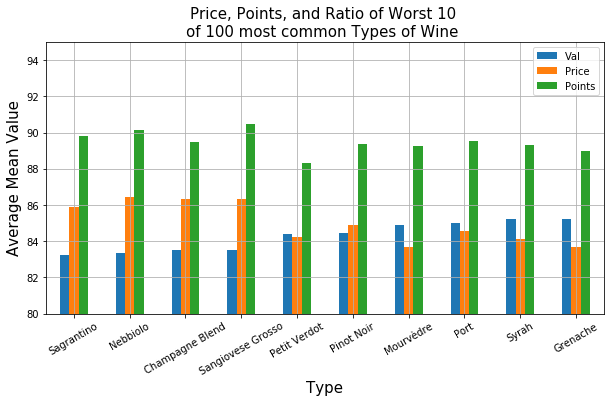

In [43]:
j=[]
jj=[]
jjj=[]
for x in sd100wkeys:
    index = sd100wkeys
    j.append(dictionary1[x])
    jj.append(dictionary3[x])
    jjj.append(dictionary5[x])
df3 = pd.DataFrame({'Val': j,
                    'Price': jj, 'Points': jjj},index=index)
ax = df3.plot.bar(rot=0, figsize = (10,5))

ax.set_ylim([80,95])
plt.ylabel('Average Mean Value', fontsize=15)
plt.xlabel('Type', fontsize=15)
plt.title('Price, Points, and Ratio of Worst 10 \nof 100 most common Types of Wine ', fontsize=15)
plt.legend(loc = 1)

plt.grid(True)

plt.xticks(rotation=30)
plt.show()

### 3) Of the 10 most common categories of wine, the top 10 ranked by value, showing value, price, and points scaled between 80-100.

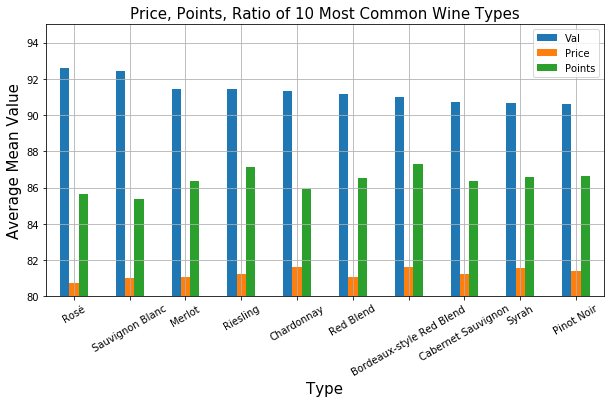

In [44]:
g=[]
gg=[]
ggg=[]
for x in sd10keys:
    index = sd10keys
    g.append(dictionary2[x])
    gg.append(dictionary4[x])
    ggg.append(dictionary6[x])
df4 = pd.DataFrame({'Val': z,
                    'Price': zz, 'Points': zzz},index=index)
ax = df4.plot.bar(rot=0, figsize = (10,5))
ax.set_ylim([80,95])
plt.ylabel('Average Mean Value', fontsize=15)
plt.xlabel('Type', fontsize=15)
plt.title('Price, Points, Ratio of 10 Most Common Wine Types', fontsize=15)
plt.legend(loc = 1)
plt.grid(True)
plt.xticks(rotation=30)
plt.show()

### Now to move on the plotting the same features by country.

In [45]:
df.country.value_counts()#Finding the most common countries

US                        53669
France                    21511
Italy                     19205
Spain                      6358
Portugal                   5319
Chile                      4265
Argentina                  3693
Austria                    3341
Australia                  2236
Germany                    2092
New Zealand                1415
South Africa               1383
Israel                      503
Greece                      463
Canada                      257
Hungary                     143
Bulgaria                    136
Uruguay                     109
Turkey                       90
Georgia                      86
Slovenia                     84
England                      74
Romania                      73
Croatia                      73
Mexico                       69
None                         61
Moldova                      56
Brazil                       52
Lebanon                      35
Morocco                      28
Peru                         16
Macedoni

In [46]:
toplocs = df.country.value_counts().index.tolist()[0:12] #Storing the top 12 values

In [47]:
toplocs

['US',
 'France',
 'Italy',
 'Spain',
 'Portugal',
 'Chile',
 'Argentina',
 'Austria',
 'Australia',
 'Germany',
 'New Zealand',
 'South Africa']

In [48]:
#Creating similar lists to the last exploration, but by country instead of category
locmeansval = []
locmeansprice = []
locmeanspoints = []

for x in toplocs:
    zz = df.loc[df['country'] == x]
    locmeansval.append(zz['OValue Ratio'].mean())
    locmeanspoints.append(zz['points'].mean())
    locmeansprice.append(zz['OPrice'].mean())              

print(locmeansval)
print(locmeansprice)
print(locmeanspoints)


[3.3025279757601815, 3.838403507281341, 3.497059993359371, 4.776762846323519, 4.874723352606922, 5.523315332972124, 5.025404022737562, 3.7763217256531667, 4.119833868135461, 3.7812133263539933, 4.113360506119245, 4.8358519929169494]
[35.492164936928205, 31.348333410813073, 34.98901327779224, 26.041679773513682, 24.692799398383155, 20.50175849941383, 24.114541023558083, 29.43370248428614, 31.542486583184257, 32.97227533460803, 26.930035335689045, 24.190889370932755]
[88.55918686765172, 88.73455441402074, 88.51195001301744, 87.29852154765649, 88.39011092310585, 86.58382180539273, 86.77362577849986, 90.09967075725831, 88.58676207513417, 89.72514340344168, 88.31166077738516, 88.06941431670282]


In [49]:
#Creating a dictionary with all the lists
toplocdf = pd.DataFrame(
    {'country': toplocs,
     'value': locmeansval,
     'price': locmeansprice,
   'points': locmeanspoints
    })

In [50]:
toplocdf.head()

,country,value,price,points
0,US,3.302528,35.492165,88.559187
1,France,3.838404,31.348333,88.734554
2,Italy,3.497060,34.989013,88.511950
3,Spain,4.776763,26.041680,87.298522
4,Portugal,4.874723,24.692799,88.390111


In [51]:
#Sorting dictionary for plotting
toplocdf.sort_values(by=['value'], ascending=False)

,country,value,price,points
5,Chile,5.523315,20.501758,86.583822
6,Argentina,5.025404,24.114541,86.773626
4,Portugal,4.874723,24.692799,88.390111
11,South Africa,4.835852,24.190889,88.069414
3,Spain,4.776763,26.041680,87.298522
8,Australia,4.119834,31.542487,88.586762
10,New Zealand,4.113361,26.930035,88.311661
1,France,3.838404,31.348333,88.734554
9,Germany,3.781213,32.972275,89.725143
7,Austria,3.776322,29.433702,90.099671


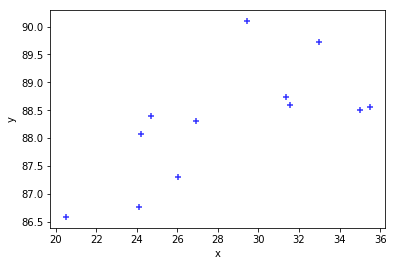

In [52]:
#Making scatterplot of this dictionary
dfscat = pd.DataFrame({
'x': locmeansprice,
'y': locmeanspoints,
'group': toplocs
})
sns.regplot(data=dfscat, x="x", y="y", fit_reg=False, marker="+", color="blue")


### This scatterplot shows price v. points for the top 10 most common countries of origin of the bottles of wine.

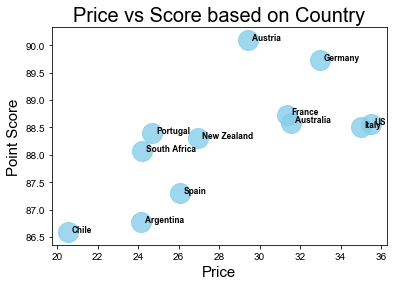

In [53]:
# basic plot
p1=sns.regplot(data=dfscat, x='x', y='y', fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':400})
# add annotations one by one with a loop
for line in range(0,dfscat.shape[0]):
     p1.text(dfscat.x[line]+.2, dfscat.y[line], dfscat.group[line], horizontalalignment='left', size='small', color='black', weight='semibold')
sns.set(rc={'figure.figsize':(10,10)})
plt.ylabel('Point Score', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.title("Price vs Score based on Country" , fontsize=20)
plt.show()



In [54]:
df.Positive.value_counts()


0    126979
Name: Positive, dtype: int64

In [55]:
scoremean

88.44713820775404

# Modeling the Data

## The classifier this project aims to build will aim to classify if a bottle has a positive or negative review based on the description of the bottle.

#### Engineering a feature's 'Positive', which designates whether the score of the bottle is above or below the average points will make classification easier.

In [56]:
#Takes a long time to run
#populating the Positive feature with an indicator if the points is above or below the mean
for x in range(1, len(df['Positive'])):
    if df['points'].iloc[x] > 88:
        df['Positive'].iloc[x] = 1

C:\Users\Brian\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [57]:
#check the distribution on the Positive feature
df.Positive.value_counts()

0    67142
1    59837
Name: Positive, dtype: int64

In [58]:
#make a new dataframe of only the columns relevant
dfnlp = pd.concat([df['description'], df['Positive']], axis=1, keys=['Description', 'Positive'])

In [59]:
dfnlp.head()

,Description,Positive
0,"Aromas include tropical fruit, broom, brimston...",0
1,"This is ripe and fruity, a wine that is smooth...",0
2,"Tart and snappy, the flavors of lime flesh and...",0
3,"Pineapple rind, lemon pith and orange blossom ...",0
4,"Much like the regular bottling from 2012, this...",0


In [60]:
dfnlp.Positive.value_counts()

0    67142
1    59837
Name: Positive, dtype: int64

In [61]:
dfnlp.head()

,Description,Positive
0,"Aromas include tropical fruit, broom, brimston...",0
1,"This is ripe and fruity, a wine that is smooth...",0
2,"Tart and snappy, the flavors of lime flesh and...",0
3,"Pineapple rind, lemon pith and orange blossom ...",0
4,"Much like the regular bottling from 2012, this...",0


In [62]:
#This is the review column
dfnlp['Description'].head()

0    Aromas include tropical fruit, broom, brimston...
1    This is ripe and fruity, a wine that is smooth...
2    Tart and snappy, the flavors of lime flesh and...
3    Pineapple rind, lemon pith and orange blossom ...
4    Much like the regular bottling from 2012, this...
Name: Description, dtype: object

#### This code cleans the text in the descriptions and prepares it for the NLP -- Sentiment Analysis process.

In [63]:
#Defining two functions, firstly to get a words positivity/ negativity score, and the second to clean text
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    text = text.lower()
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    text = [word for word in text if not any(c.isdigit() for c in word)]
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    text = [t for t in text if len(t) > 0]
    pos_tags = pos_tag(text)
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    text = [t for t in text if len(t) > 1]
    text = " ".join(text)
    return(text)

dfnlp.head(2)

,Description,Positive
0,"Aromas include tropical fruit, broom, brimston...",0
1,"This is ripe and fruity, a wine that is smooth...",0


Now to apply it to our text corpus

In [64]:
#Apply the text cleaning function to our descriptions
dfnlp["review_clean"] = dfnlp["Description"].apply(lambda x: clean_text(x))

In [65]:
dfnlp.head(2)

,Description,Positive,review_clean
0,"Aromas include tropical fruit, broom, brimston...",0,aroma include tropical fruit broom brimstone d...
1,"This is ripe and fruity, a wine that is smooth...",0,ripe fruity wine smooth still structure firm t...


### Now to add some features that will be used in sentiment Analysis.

In [66]:
#Run the polarity score function to text
sid = SentimentIntensityAnalyzer()
dfnlp["sentiments"] = dfnlp["Description"].apply(lambda x: sid.polarity_scores(x))
dfnlp = pd.concat([dfnlp.drop(['sentiments'], axis=1), dfnlp['sentiments'].apply(pd.Series)], axis=1)

In [67]:
dfnlp.head(2)

,Description,Positive,review_clean,neg,neu,pos,compound
0,"Aromas include tropical fruit, broom, brimston...",0,aroma include tropical fruit broom brimstone d...,0.0,0.935,0.065,0.1531
1,"This is ripe and fruity, a wine that is smooth...",0,ripe fruity wine smooth still structure firm t...,0.0,0.868,0.132,0.6486


In [68]:
#Make two new features of number of characters and words
dfnlp["nb_chars"] = dfnlp["Description"].apply(lambda x: len(x))
dfnlp["nb_words"] = dfnlp["Description"].apply(lambda x: len(x.split(" ")))

In [69]:
#Make a new column of the uncleaned description
dfnlp["review_clean1"] = dfnlp["review_clean"]
dfnlp.head()

,Description,Positive,review_clean,neg,neu,pos,compound,nb_chars,nb_words,review_clean1
0,"Aromas include tropical fruit, broom, brimston...",0,aroma include tropical fruit broom brimstone d...,0.000,0.935,0.065,0.1531,172,24,aroma include tropical fruit broom brimstone d...
1,"This is ripe and fruity, a wine that is smooth...",0,ripe fruity wine smooth still structure firm t...,0.000,0.868,0.132,0.6486,227,39,ripe fruity wine smooth still structure firm t...
2,"Tart and snappy, the flavors of lime flesh and...",0,tart snappy flavor lime flesh rind dominate gr...,0.053,0.947,0.000,-0.1280,186,28,tart snappy flavor lime flesh rind dominate gr...
3,"Pineapple rind, lemon pith and orange blossom ...",0,pineapple rind lemon pith orange blossom start...,0.000,0.926,0.074,0.3400,199,33,pineapple rind lemon pith orange blossom start...
4,"Much like the regular bottling from 2012, this...",0,much like regular bottle come across rather ro...,0.000,0.805,0.195,0.8176,249,41,much like regular bottle come across rather ro...



#### Now to vectorize the text, training a Doc2Vec model.

In [70]:
#Splitting, vectorizing, and doc2vec
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(dfnlp["review_clean"].apply(lambda x: x.split(" ")))]
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)
doc2vec_df = dfnlp["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
dfnlp = pd.concat([dfnlp, doc2vec_df], axis=1)

In [71]:
dfnlp.head(1)

,Description,Positive,review_clean,neg,neu,pos,compound,nb_chars,nb_words,review_clean1,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
0,"Aromas include tropical fruit, broom, brimston...",0,aroma include tropical fruit broom brimstone d...,0.0,0.935,0.065,0.1531,172,24,aroma include tropical fruit broom brimstone d...,-0.128025,-0.145526,-0.023689,-0.004693,0.036808


In [72]:
dfnlp["Positive"].value_counts(normalize = True)

0    0.528765
1    0.471235
Name: Positive, dtype: float64

In [73]:
dfnlp.head(2)

,Description,Positive,review_clean,neg,neu,pos,compound,nb_chars,nb_words,review_clean1,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
0,"Aromas include tropical fruit, broom, brimston...",0,aroma include tropical fruit broom brimstone d...,0.0,0.935,0.065,0.1531,172,24,aroma include tropical fruit broom brimstone d...,-0.128025,-0.145526,-0.023689,-0.004693,0.036808
1,"This is ripe and fruity, a wine that is smooth...",0,ripe fruity wine smooth still structure firm t...,0.0,0.868,0.132,0.6486,227,39,ripe fruity wine smooth still structure firm t...,0.006676,0.096279,-0.221475,-0.098894,-0.077702


#### This section uses Word2Vec in order to gain insight into the tokenized words, and which words are most similar to other words.

In [74]:
#Here, the cleaned reviews is plugged into a word2vec model
data1 = dfnlp['review_clean1'].map(word_tokenize)
model1 = Word2Vec(data1, size=100, window=5, min_count=1, workers=4)
model1.train(data1, total_examples=model1.corpus_count, epochs=10)
wv = model1.wv

#### The WOrd2Vec most similar score, by combining a positive/negative word with red and white, we can see what properties make good and bd red or white wines

In [75]:
wv.most_similar(['red', 'good'])

[('nice', 0.6115314364433289),
 ('great', 0.5324559211730957),
 ('fine', 0.5290143489837646),
 ('solid', 0.5266011953353882),
 ('black', 0.5251845717430115),
 ('decent', 0.5101558566093445),
 ('plenty', 0.4827231168746948),
 ('cassis-liqueur', 0.46965670585632324),
 ('pleasant', 0.4671422839164734),
 ('attractive', 0.45366042852401733)]

In [76]:
wv.most_similar(['white', 'good'])

[('nice', 0.5871288776397705),
 ('great', 0.5125147104263306),
 ('fine', 0.4883992075920105),
 ('check—ideal', 0.46585071086883545),
 ('decent', 0.4483624994754791),
 ('solid', 0.4467141032218933),
 ('fresh', 0.4381512999534607),
 ('fruit/white', 0.43494200706481934),
 ('excellent', 0.4280073940753937),
 ('oaky-butterscotch', 0.4265824854373932)]

In [77]:
wv.most_similar(['white', 'bad'])

[('bell', 0.5547558069229126),
 ('chili', 0.48030826449394226),
 ('can', 0.47043657302856445),
 ('surprisngly', 0.46667030453681946),
 ('okay', 0.45969051122665405),
 ('dr', 0.43521592020988464),
 ('unripe', 0.42991533875465393),
 ('underwhelming', 0.4234706163406372),
 ('cypher', 0.42255544662475586),
 ('acceptable', 0.4205368757247925)]

In [78]:
wv.most_similar(['red', 'bad'])

[('bell', 0.5547558069229126),
 ('chili', 0.48030826449394226),
 ('can', 0.47043657302856445),
 ('surprisngly', 0.46667030453681946),
 ('okay', 0.45969051122665405),
 ('dr', 0.43521592020988464),
 ('unripe', 0.42991533875465393),
 ('underwhelming', 0.4234706163406372),
 ('cypher', 0.42255544662475586),
 ('acceptable', 0.4205368757247925)]

#### A nice visualization to understand the text corpus is a word cloud, showing the most common and important words in the description column.

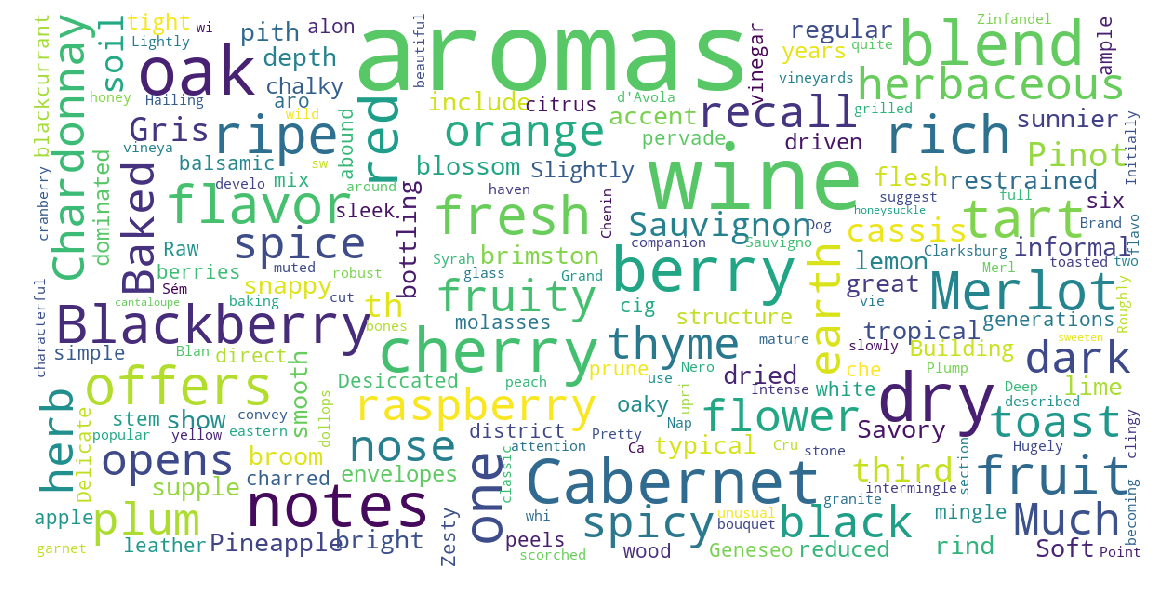

In [79]:
#Now to build a word cloud
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(dfnlp["Description"])

#### Take a look at the most positive and most negative descriptions.

In [80]:
dfnlp.head()

,Description,Positive,review_clean,neg,neu,pos,compound,nb_chars,nb_words,review_clean1,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
0,"Aromas include tropical fruit, broom, brimston...",0,aroma include tropical fruit broom brimstone d...,0.000,0.935,0.065,0.1531,172,24,aroma include tropical fruit broom brimstone d...,-0.128025,-0.145526,-0.023689,-0.004693,0.036808
1,"This is ripe and fruity, a wine that is smooth...",0,ripe fruity wine smooth still structure firm t...,0.000,0.868,0.132,0.6486,227,39,ripe fruity wine smooth still structure firm t...,0.006676,0.096279,-0.221475,-0.098894,-0.077702
2,"Tart and snappy, the flavors of lime flesh and...",0,tart snappy flavor lime flesh rind dominate gr...,0.053,0.947,0.000,-0.1280,186,28,tart snappy flavor lime flesh rind dominate gr...,-0.062308,-0.164263,-0.168304,0.062051,-0.100466
3,"Pineapple rind, lemon pith and orange blossom ...",0,pineapple rind lemon pith orange blossom start...,0.000,0.926,0.074,0.3400,199,33,pineapple rind lemon pith orange blossom start...,-0.001491,-0.034011,-0.037806,0.015995,-0.058114
4,"Much like the regular bottling from 2012, this...",0,much like regular bottle come across rather ro...,0.000,0.805,0.195,0.8176,249,41,much like regular bottle come across rather ro...,0.042481,-0.019908,0.071146,-0.139212,-0.306635


In [81]:
#Check the most positive reviews
dfnlp[dfnlp["nb_words"] >= 5].sort_values("pos", ascending = False)[["Description", "pos"]].head(10)

,Description,pos
117686,"A fine, clean and intense sparkling wine, with...",0.619
105733,"88-90 Barrel sample. This is rich, with sweet ...",0.606
26305,"The honey, orange, pineapple-jam and vanilla f...",0.605
67941,"Fine fresh fruits, bright with good acidity an...",0.580
24704,"Attractive perfumed wine, rich, soft, generous...",0.574
89959,Apple fruitiness dominates this fresh sparklin...,0.572
35853,"91-93 Smooth, rich strong wine, with delicious...",0.570
116097,97-99 Barrel sample. A wonderfully structured ...,0.570
86499,"This is a light, bright wine, certainly with s...",0.562
76500,"Yes, there is some elegance here as well as ri...",0.558


In [82]:
#Check the most negative reviews
dfnlp[dfnlp["nb_words"] >= 5].sort_values("neg", ascending = False)[["Description", "neg"]].head(10)

,Description,neg
26885,"This is sour, bitter and just all-around dull ...",0.509
87189,Disagreeable for its harsh acidity and vegetal...,0.453
15608,"Smells baked and hot, tastes harsh and dry, a ...",0.443
99910,This is a yeasty wine that shows a bitter almo...,0.372
103989,This suffers from major problems. It has all t...,0.371
79700,"This wine combines green, herbal overtones wit...",0.354
108268,"Dry, dark-hued tannins cut through the wine, g...",0.344
3622,"Soft, with a severe cut of acidity slicing thr...",0.343
123521,"A pruny, overripe Merlot that feels harsh and ...",0.341
21037,The wine is extracted and hard. It has a tough...,0.337


#### Plotting the density plots

C:\Users\Brian\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


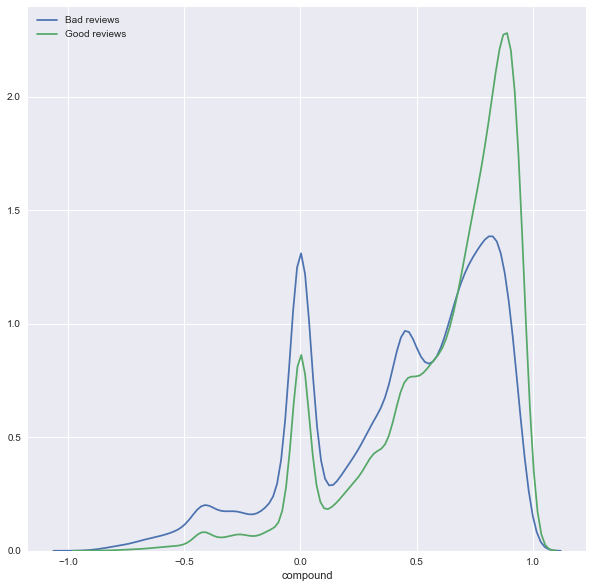

In [83]:
#Plotting the density of positive and negative reviews with line graphs
for x in [0, 1]:
    subset = dfnlp[dfnlp['Positive'] == x]
    if x == 0:
        label = "Bad reviews"
    else:
        label = "Good reviews"
    sns.distplot(subset['compound'], hist = False, label = label)

#### Check out the feature importance for feature selection. Then, split the data into test and train data in order to train and then test the model.

In [84]:
# feature selection
label = "Positive"
ignore_cols = [label, "Description", "review_clean", "review_clean1"]
features = [c for c in dfnlp.columns if c not in ignore_cols]

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(dfnlp[features], dfnlp[label], test_size = 0.20, random_state = 42)


#### Now to train the classifier, a random forest will provide a good method of determining whether a review is good or bad.

In [85]:
#Build Random Forest Classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

,feature,importance
4,nb_chars,0.197348
5,nb_words,0.110162
7,doc2vec_vector_1,0.099749
8,doc2vec_vector_2,0.089544
9,doc2vec_vector_3,0.088989
10,doc2vec_vector_4,0.087746
6,doc2vec_vector_0,0.086495
3,compound,0.085947
2,pos,0.067339
1,neu,0.062178


#### This code plots the ROC graphs, to see the tradeoff between False Positives and True positives.


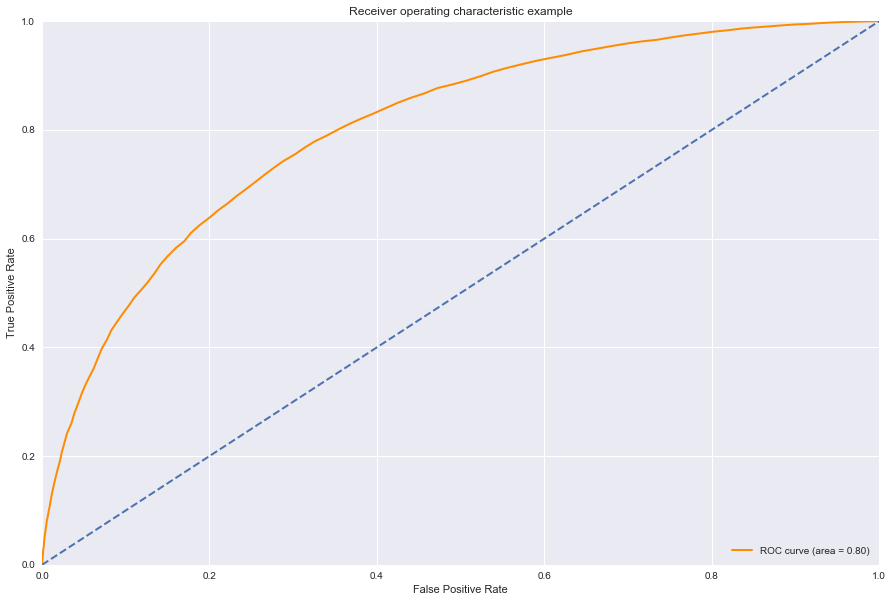

In [86]:
#Plotting the line graph of the ROC function
y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)
roc_auc = auc(fpr, tpr)
plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### Now to plot the tradeoff between Precision and recall of the model

Text(0.5,1,'2-class Precision-Recall curve: AP=0.78')

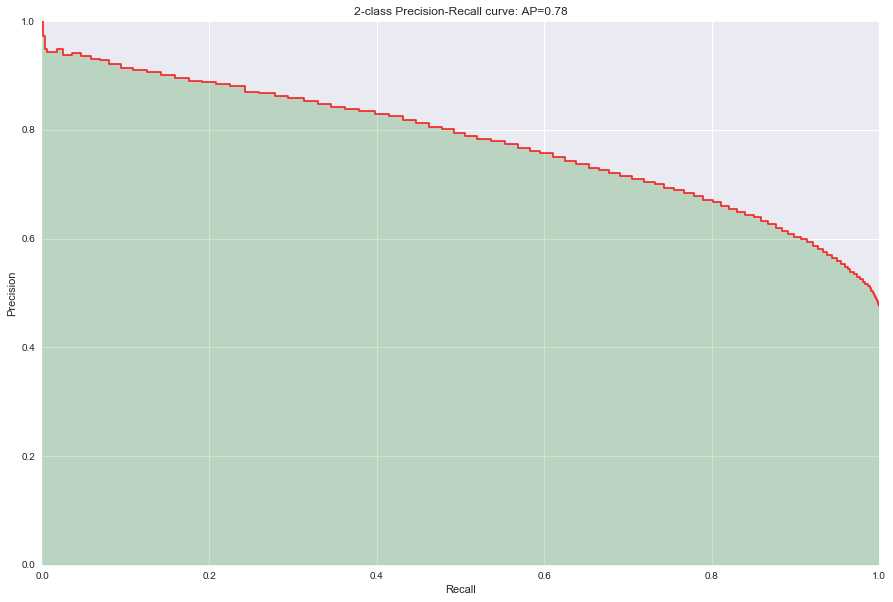

In [87]:
# Using shaded line graph to plot precision v recall
average_precision = average_precision_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='r', alpha=0.8,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='g', **step_kwargs)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

# Conclusion  --  Interpreting the Data

#### Now to look into the performance of the model by looking at the accuracy, testing and training, and building a confusion matrix to visualize the proportion of True Positive and negatives, and false Positives and negatives.

In [88]:
average_precision

0.7768826743610193

In [89]:
rf.score(X_train, y_train)
#X_train, X_test, y_train, y_test

1.0

In [90]:
rf.score(X_test, y_test)

0.7253110726098598

In [91]:
y_hat_test = rf.predict(X_test)

In [92]:
#Simple confusion matrix
cnf_matrix = confusion_matrix(y_hat_test, y_test)
print('Confusion Matrix:\n',cnf_matrix)

Confusion Matrix:
 [[10091  3741]
 [ 3235  8329]]


Confusion matrix, without normalization
[[10091  3741]
 [ 3235  8329]]
Normalized confusion matrix
[[0.73 0.27]
 [0.28 0.72]]


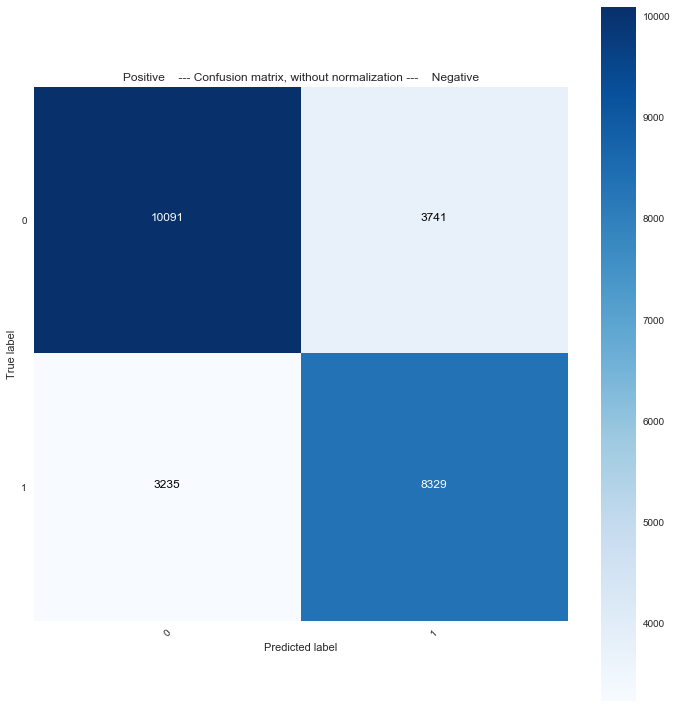

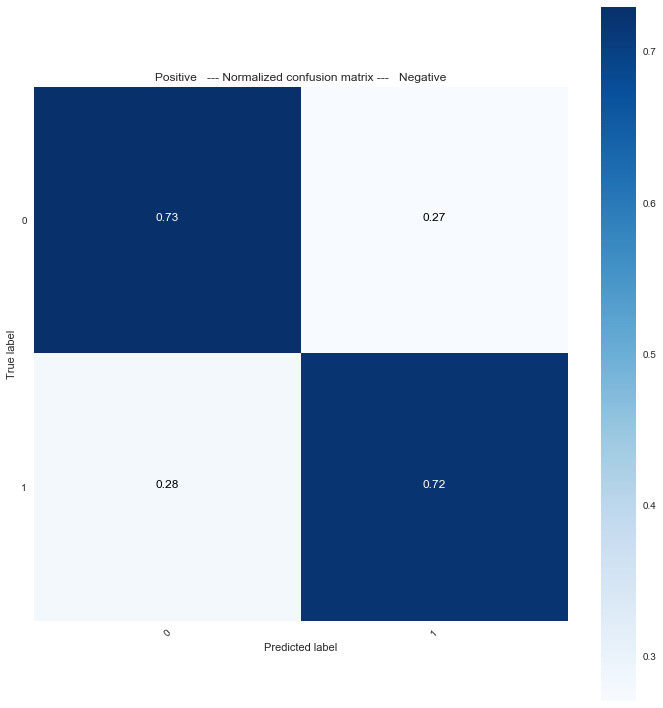

In [121]:
#Building aesthetic  confusion matrix function and applying it to RF Classifier
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.grid(b=None)
    

np.set_printoptions(precision=2)
class_names = ['0','1']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Positive    --- Confusion matrix, without normalization ---    Negative')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Positive   --- Normalized confusion matrix ---   Negative')

plt.show()

Accuracy: 72.53%

Precision: 73.00%

Recall: 75.59%

F1 Score: 74.29


## The performance of the model performed around 23% better than random guessing, which is fairly good considering the breadth of the task. Overall, the description can be used to classify the outcome of the review around 73% of the time.

In [94]:
#Building the base for the RNN Classifier
#Splitting data into features and target
X = dfnlp.review_clean1
Y = dfnlp['Positive']
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [95]:
#New test train split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [96]:
#Tokenizing words
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [97]:
#Defining RNN function
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [98]:
#Building the model
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
__________

In [99]:
#Running the model
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=5,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 86345 samples, validate on 21587 samples
Epoch 1/5
86345/86345 [==============================] - 147s 2ms/step - loss: 0.4482 - acc: 0.7844 - val_loss: 0.4376 - val_acc: 0.7951
Epoch 2/5
86345/86345 [==============================] - 147s 2ms/step - loss: 0.4107 - acc: 0.8078 - val_loss: 0.4092 - val_acc: 0.8079
Epoch 3/5
86345/86345 [==============================] - 148s 2ms/step - loss: 0.4020 - acc: 0.8121 - val_loss: 0.4098 - val_acc: 0.8057


In [100]:
#Testing performance
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [101]:
#Evaluating accuracy
accr = model.evaluate(test_sequences_matrix,Y_test)

19047/19047 [==============================] - 11s 583us/step


In [102]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.412
  Accuracy: 0.807


Text(0,0.5,'Performance')

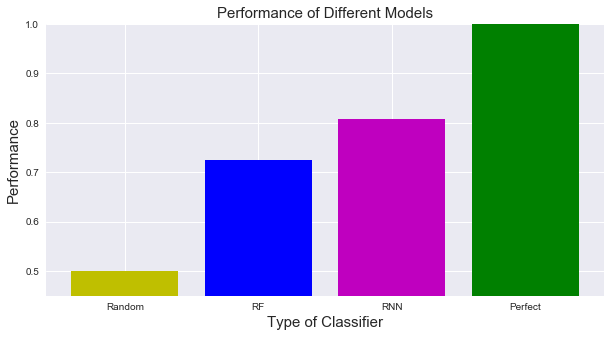

In [158]:
from matplotlib.pyplot import figure
typelist = ['Random' , 'RF', 'RNN', 'Perfect']
perflist = [.5 , .7253, .807, 1]
figure(num=None, figsize=(10, 5))
plt.bar(typelist, perflist, color=['y', 'b', 'm' , 'g'])

plt.title('Performance of Different Models', fontsize =15)
plt.xlabel('Type of Classifier', fontsize =15)
plt.ylim(.45, 1)
plt.ylabel('Performance', fontsize =15)


# Final Conclusion

#### A random classification would perform, theoretically, at 50%. The random forest classifier performs at around 73% accuracy. The RNN performed at around 80%. A perfect classifier would of course perform at 100%. So the Neural Network perform best at determining which description will yield positive reviews, with an accuracy of 80%. 